In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
sys.path.append('../')
import _redshift_richness_bins as analysis
import pyccl as ccl
import clmm
from clmm import Cosmology
%load_ext autoreload
%autoreload 2

def binning(corner): return [[corner[i],corner[i+1]] for i in range(len(corner)-1)]

In [2]:
suff = '_partial_coverage'
data_BPZ = np.load(f'../data/stacked_esd_profiles_redmapper_true{suff}.pkl', allow_pickle=True)
profiles_BPZ = data_BPZ['stacked profile']
covariances_BPZ = data_BPZ['stacked covariance']

In [3]:
data_random_BPZ = np.load(f'../data/stacked_esd_profiles_redmapper_random_true{suff}.pkl', allow_pickle=True)
profiles_random_BPZ = data_random_BPZ['stacked profile']
covariances_random_BPZ = data_random_BPZ['stacked covariance']

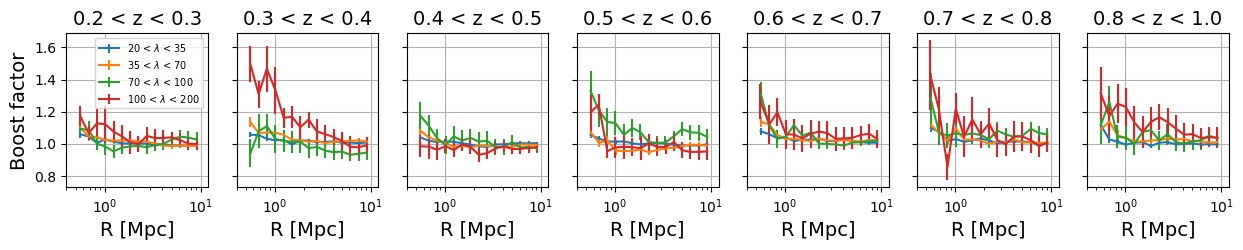

In [ ]:
suff_ls = '_true'
Z_bin = analysis.Z_bin
Obs_bin = analysis.Obs_bin
n_z_bin = len(Z_bin) 
fig, axs = plt.subplots(1, n_z_bin, figsize = (15,2), sharey=True)
for j, z_bin in enumerate(Z_bin):
    for i, m_bin in enumerate(Obs_bin):
        
            label_z =   f'{z_bin[0]:.1f} < z < {z_bin[1]:.1f}'
            label_M = f'{m_bin[0]:.0f} < ' + r'$\lambda$' +f' < {m_bin[1]:.0f}'
            
            mask_z = (profiles_BPZ['z_mean'] > z_bin[0])*(profiles_BPZ['z_mean'] < z_bin[1])
            mask_m = (profiles_BPZ['obs_mean'] > m_bin[0])*(profiles_BPZ['obs_mean'] < m_bin[1])
        
            
            up = np.mean(profiles_BPZ['W_l'+suff_ls][mask_z*mask_m][0], axis=0)
            err_up = np.std(profiles_BPZ['W_l'+suff_ls][mask_z*mask_m][0], axis=0)
            err_up = err_up/np.sqrt(len(profiles_BPZ['W_l'+suff_ls][mask_z*mask_m][0]))
            
            mask_z_random = (profiles_random_BPZ['z_mean'] > z_bin[0])*(profiles_random_BPZ['z_mean'] < z_bin[1])
            mask_m_random = (profiles_random_BPZ['obs_mean'] > m_bin[0])*(profiles_random_BPZ['obs_mean'] < m_bin[1])
            
            n_random = len(profiles_random_BPZ['W_l'+suff_ls][mask_z_random*mask_m_random][0])
            n = len(profiles_BPZ['W_l'+suff_ls][mask_z*mask_m][0])
            #if n < 20: continue

            down = np.mean(profiles_random_BPZ['W_l'+suff_ls][mask_z_random*mask_m_random][0], axis=0)
            err_down = np.std(profiles_random_BPZ['W_l'+suff_ls][mask_z_random*mask_m_random][0], axis=0)
            err_down = err_down/np.sqrt(len(profiles_random_BPZ['W_l'+suff_ls][mask_z_random*mask_m_random][0]))
            ratio = up/down
            err_ratio2 = err_up**2/(down**2) - (up/down)**2*(err_down**2)
            x = profiles_random_BPZ['radius'][mask_z*mask_m][0]
            
            axs[j].errorbar(x, ratio, err_ratio2**.5, label = label_M)
            axs[j].set_xlim(0.4, 12)
            #axs[j].set_ylim(0.9, 1.5)
            axs[j].set_xscale('log')
            #axs[j].set_yscale('log')
            axs[j].set_xlabel('R [Mpc]', fontsize = 14)
            axs[j].set_title(label_z, fontsize = 14)
            axs[j].grid(True)
            axs[0].set_ylabel('Boost factor', fontsize = 14)
            axs[0].legend(fontsize=7)
#plt.savefig(f'../fig/redmapper_contamination_boost_factor.png', bbox_inches='tight', dpi=100)

In [5]:
richness_grid = np.logspace(np.log10(2), np.log10(500), 310)
logm_grid = np.linspace(11, 16, 30)
z_grid = np.linspace(.1, 1, 301)

z_edges = analysis.z_corner
Z_bin = binning(z_edges)
richness_edges = analysis.rich_corner
Richness_bin = binning(richness_edges)
#cosmology
Omega_c_true = 0.30711 - 0.048254
Omega_b_true = 0.048254
sigma8_true = .8288
Omegam_true = 0.30711
True_value = [Omega_c_true + Omega_b_true, sigma8_true]
cosmo_clmm = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)
cosmo = ccl.Cosmology(Omega_c = Omega_c_true, Omega_b = Omega_b_true, h = 0.6777, sigma8 = sigma8_true, n_s=0.96)
#halo model
massdef = ccl.halos.massdef.MassDef('vir', 'critical',)# c_m_relation=None)
hmd = ccl.halos.hmfunc.MassFuncDespali16( mass_def=massdef)
#purity
a_nc, b_nc, a_rc, b_rc = np.log(10)*0.8612, np.log(10)*0.3527, 2.2183, -0.6592
theta_purity = [a_nc, b_nc, a_rc, b_rc]
#completeness
a_nc, b_nc, a_mc, b_mc = 1.1321, 0.7751, 13.31, 0.2025
theta_completeness = [a_nc, b_nc, a_mc, b_mc]
#rm_relation
log10m0, z0 = np.log10(10**14.2), .4
proxy_mu0, proxy_muz, proxy_mulog10m =  3.091, 0, 1.05*np.log(10)
proxy_sigma0, proxy_sigmaz, proxy_sigmalog10m =  0.594, 0., 0.026*np.log(10)
theta_rm = [log10m0, z0, proxy_mu0, proxy_muz, proxy_mulog10m, proxy_sigma0, proxy_sigmaz, proxy_sigmalog10m]


In [6]:
cosmo_clmm = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)
cosmo_ccl = ccl.Cosmology(Omega_c = Omega_c_true, Omega_b = Omega_b_true, h = 0.6777, sigma8 = sigma8_true, n_s=0.96)

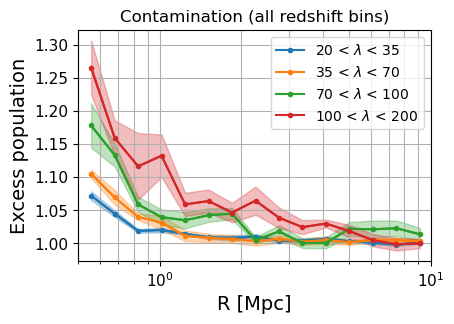

In [ ]:
suff_ls = '_true'
Z_bin = analysis.Z_bin
Obs_bin = analysis.Obs_bin
n_z_bin = len(Z_bin) - 0
plt.figure(figsize=(10,3))
plt.subplot(121)
for i, m_bin in enumerate(Obs_bin):
        ratio = np.zeros([len(profiles_random_BPZ['radius'][0]), n_z_bin])
        for j, z_bin in enumerate(Z_bin[:n_z_bin]):
        
            label_z =   f'{z_bin[0]:.1f} < z < {z_bin[1]:.1f}'
            label_M = f'{m_bin[0]:.0f} < ' + r'$\lambda$' +f' < {m_bin[1]:.0f}'
            
            mask_z = (profiles_BPZ['z_mean'] > z_bin[0])*(profiles_BPZ['z_mean'] < z_bin[1])
            mask_m = (profiles_BPZ['obs_mean'] > m_bin[0])*(profiles_BPZ['obs_mean'] < m_bin[1])
            
            mask_z_random = (profiles_random_BPZ['z_mean'] > z_bin[0])*(profiles_random_BPZ['z_mean'] < z_bin[1])
            mask_m_random = (profiles_random_BPZ['obs_mean'] > m_bin[0])*(profiles_random_BPZ['obs_mean'] < m_bin[1])
            
            #print(len(profiles_BPZ['W_l'+suff_ls][mask_z*mask_m][0]), len(profiles_random_BPZ['W_l'+suff_ls][mask_z_random*mask_m_random][0]))
            up = np.mean(profiles_BPZ['W_l'+suff_ls][mask_z*mask_m][0], axis=0)
            down = np.mean(profiles_random_BPZ['W_l'+suff_ls][mask_z_random*mask_m_random][0], axis=0)
            ratio[:,j] = up/down
            
        boost_factor = []
            
        meanz=np.mean(profiles_BPZ['z_mean'])
        richness = np.mean(m_bin)
        logm200c = log10m0 + (1/proxy_mulog10m)*np.log(richness/(10**proxy_mu0)) + np.log((1+meanz)/(1+z0))*(-proxy_muz/proxy_mulog10m)
        r200c = clmm.compute_rdelta(mdelta=10**logm200c, redshift=meanz, 
                                        cosmo=cosmo_clmm, massdef='critical', delta_mdef=200)
        deff = ccl.halos.massdef.MassDef(200, 'critical')
        conc = ccl.halos.concentration.ConcentrationDiemer15(mass_def=deff)
        concentration = conc._concentration(cosmo_ccl, 10**logm200c, 1./(1. + meanz))
        rs = r200c / concentration
        import clmm.utils as u
        r = np.linspace(0.5,10,200)
        boost_factor_grid = boost_factor.append(u.compute_nfw_boost(r, rscale=0.8, boost0=0.34))
            
        plt.fill_between(profiles_random_BPZ['radius'][0], 
                         np.mean(ratio, axis=1)+ np.std(ratio, axis=1)/np.sqrt(len(ratio)),
                         np.mean(ratio, axis=1)- np.std(ratio, axis=1)/np.sqrt(len(ratio)), alpha=.3, color = 'C'+str(i))
        plt.plot(profiles_random_BPZ['radius'][0], np.mean(ratio, axis=1), color = 'C'+str(i))
        
        plt.plot(profiles_random_BPZ['radius'][0], 
                        np.mean(ratio, axis=1) , marker='.', 
                 label=label_M,  color = 'C'+str(i))
        
        
plt.xlim(0.5, 10)
#plt.ylim(0, 2)
plt.xscale('log')
plt.ylabel('Excess population', fontsize = 14)
plt.xlabel('R [Mpc]', fontsize = 14)
plt.legend(loc='upper right')
plt.grid(True, which="both", ls="-")
plt.title('Contamination (all redshift bins)')
plt.tick_params(axis='both', which = 'both', labelsize= 11)
plt.savefig(f'../fig/redmapper_magnification_boost_factor_paper.png', bbox_inches='tight', dpi=100)

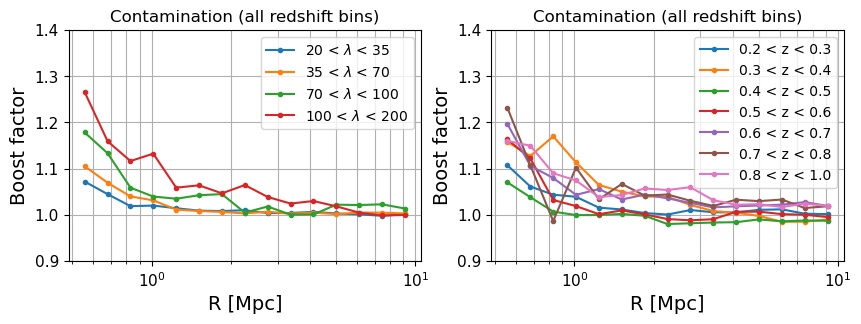

In [ ]:
suff_ls = '_true'
Z_bin = analysis.Z_bin
Obs_bin = analysis.Obs_bin
n_z_bin = len(Z_bin) 
plt.figure(figsize=(10,3))
plt.subplot(121)
for i, m_bin in enumerate(Obs_bin):
        ratio = np.zeros([len(profiles_random_BPZ['radius'][0]), n_z_bin])
        for j, z_bin in enumerate(Z_bin):
        
            label_z =   f'{z_bin[0]:.1f} < z < {z_bin[1]:.1f}'
            label_M = f'{m_bin[0]:.0f} < ' + r'$\lambda$' +f' < {m_bin[1]:.0f}'
            
            mask_z = (profiles_BPZ['z_mean'] > z_bin[0])*(profiles_BPZ['z_mean'] < z_bin[1])
            mask_m = (profiles_BPZ['obs_mean'] > m_bin[0])*(profiles_BPZ['obs_mean'] < m_bin[1])
            
            mask_z_random = (profiles_random_BPZ['z_mean'] > z_bin[0])*(profiles_random_BPZ['z_mean'] < z_bin[1])
            mask_m_random = (profiles_random_BPZ['obs_mean'] > m_bin[0])*(profiles_random_BPZ['obs_mean'] < m_bin[1])
            
            #print(len(profiles_BPZ['W_l'+suff_ls][mask_z*mask_m][0]), len(profiles_random_BPZ['W_l'+suff_ls][mask_z_random*mask_m_random][0]))
            up = np.mean(profiles_BPZ['W_l'+suff_ls][mask_z*mask_m][0], axis=0)
            down = np.mean(profiles_random_BPZ['W_l'+suff_ls][mask_z_random*mask_m_random][0], axis=0)
            ratio[:,j] = up/down
            
        #plt.fill_between(profiles_random_BPZ['radius'][0], 
        #                 np.mean(ratio, axis=1)+ np.std(ratio, axis=1),
        #                 np.mean(ratio, axis=1)- np.std(ratio, axis=1),label = label_M, alpha=.4)
        
        plt.plot(profiles_random_BPZ['radius'][0], 
                         np.mean(ratio, axis=1), marker='.', label=label_M)

plt.ylim(0.9, 1.4)
plt.xscale('log')
plt.ylabel('Boost factor', fontsize = 14)
plt.xlabel('R [Mpc]', fontsize = 14)
plt.legend(loc='upper right')
plt.grid(True, which="both", ls="-")
plt.title('Contamination (all redshift bins)')
plt.tick_params(axis='both', which = 'both', labelsize= 11)
suff_ls = '_true'
Z_bin = analysis.Z_bin
Obs_bin = analysis.Obs_bin
n_z_bin = len(Z_bin) 
plt.subplot(122)
for i, z_bin in enumerate(Z_bin):
        ratio = np.zeros([len(profiles_random_BPZ['radius'][0]), len(Obs_bin)])
        for j, m_bin in enumerate(Obs_bin):
        
            label_z =   f'{z_bin[0]:.1f} < z < {z_bin[1]:.1f}'
            label_M = f'{m_bin[0]:.0f} < ' + r'$\lambda$' +f' < {m_bin[1]:.0f}'
            
            mask_z = (profiles_BPZ['z_mean'] > z_bin[0])*(profiles_BPZ['z_mean'] < z_bin[1])
            mask_m = (profiles_BPZ['obs_mean'] > m_bin[0])*(profiles_BPZ['obs_mean'] < m_bin[1])
            
            mask_z_random = (profiles_random_BPZ['z_mean'] > z_bin[0])*(profiles_random_BPZ['z_mean'] < z_bin[1])
            mask_m_random = (profiles_random_BPZ['obs_mean'] > m_bin[0])*(profiles_random_BPZ['obs_mean'] < m_bin[1])
            
            #print(len(profiles_BPZ['W_l'+suff_ls][mask_z*mask_m][0]), len(profiles_random_BPZ['W_l'+suff_ls][mask_z_random*mask_m_random][0]))
            up = np.mean(profiles_BPZ['W_l'+suff_ls][mask_z*mask_m][0], axis=0)
            down = np.mean(profiles_random_BPZ['W_l'+suff_ls][mask_z_random*mask_m_random][0] ,axis=0)
            ratio[:,j] = up/down
            

        plt.plot(profiles_random_BPZ['radius'][0], 
                         np.mean(ratio, axis=1), marker='.', label=label_z)

plt.ylim(0.9, 1.4)
plt.xscale('log')
plt.ylabel('Boost factor', fontsize = 14)
plt.xlabel('R [Mpc]', fontsize = 14)
plt.legend(loc='upper right')
plt.grid(True, which="both", ls="-")
plt.title('Contamination (all redshift bins)')
plt.tick_params(axis='both', which = 'both', labelsize= 11)
plt.savefig(f'../fig/redmapper_contamination_boost_factor_all_z_bins.png', bbox_inches='tight', dpi=100)